In [1]:
# importing relevant modules
import matplotlib.pyplot   as plt

from pandas                import read_csv, to_datetime
from numpy                 import reshape, array
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers          import Dense, Dropout, LSTM, Input, TimeDistributed
from keras.models          import Model
from keras_tqdm            import TQDMNotebookCallback
from IPython.display       import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.callbacks       import EarlyStopping

%matplotlib inline

/home/csci4850/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### The sample Data used for this demo conatians bitcoin stock price from 12/4/2016 to 3/27/2018. The input attribute in order are Timestamp (in unix time), starting price(open), highest price(high), lowest price(low), closing price(close), volume of bitcoin exchanged(volume_BTC), volume of currency for the bitcoins(volume_currency), weighted price. All prices are in US dollars. Sample of the dataset is shown below.
#### All datasets were taken from https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [2]:
#For Demonistration purpose only, 
rawData = read_csv('sample_data.csv')
rawData[0:5]  #first five records in the dataset

,Timestamp,Open,High,Low,Close,Volume_.BTC.,Volume_.Currency.,Weighted_Price
0,1480913160,758.12,758.20,758.12,758.13,5.76837,4373.355968,758.161485
1,1480913220,758.18,758.18,758.00,758.18,2.20489,1671.407708,758.045847
2,1480913280,758.08,758.08,758.08,758.08,2.44986,1857.189869,758.080000
3,1480913340,758.19,758.20,758.19,758.20,1.39213,1055.512856,758.199921
4,1480913400,758.19,758.20,758.19,758.20,0.49255,373.450410,758.197970


In [3]:
def Read_File(file: int = 0, split: float = 0.05, reduce: int = 0):          #File size (in MB)
  
    # Read input sample data into a data frame.
    df = read_csv('sample_data.csv')
    
    # Append 'date' column to the sample dataframe.
    # Uses the Unix timestamp to create equivalent date
    # This attribute will be used to calculate the daily weighted average
    df['date'] = to_datetime(df['Timestamp'],unit='s').dt.date
    
    # Store the average weighted price per day (in USD).
    daily_average = [df.groupby('date')['Weighted_Price'].mean(),
                     df.groupby('date')['Weighted_Price'].mean()][0].values
    
    #reduce file, if desired.
    if reduce and reduce < len(daily_average):
        daily_average = daily_average[len(daily_average) - 1 - reduce:]
        
    #Gaurantees at least one testing example.
    partition     = min(-int(split*len(daily_average)), -1)
    
    training_set, testing_set = daily_average[:partition], daily_average[partition:]
    
    # Create instance of min-max scaler.
    sc                        = MinMaxScaler(feature_range = (0, 1))
    
    # Reshape training and testing sets and then perform min-max scaling.
    training_set, testing_set = sc.fit_transform(reshape(training_set, (len(training_set), 1))), \
                                sc.transform(reshape(testing_set, (len(testing_set), 1)))
    
    
    return training_set[:-1], training_set[1:], testing_set[:-1], testing_set[1:], sc

In [4]:
#Plot results.
def Plot(data1, data2, title: str = '', label1: str = '', label2: str = '', ylabel: str = '', scatter: bool = True):
    plt.figure(figsize   = (25,15),
               dpi       = 80,
               facecolor = 'w',
               edgecolor = 'k')
    
    ax = plt.gca()

    x  = [_ for _ in range(len(data1))]
    
    if scatter:
        plt.plot(data1, 
                 color = '#AA00FF',
                 ls    = 'dashed')
        plt.plot(data2,
                 color = '#000000',
                 ls    = 'dashed')
        plt.scatter(x,
                   data1,
                   label = label1,
                   color = '#AA00FF',
                   s     = 50)
        plt.scatter(x,
                   data2,
                   label = label2,
                   color = '#000000',
                   s     = 50)
    else:
        plt.bar(x,
                reshape(data1, (len(data1))),
                label = label1,
                color = '#AA00FF')
        plt.bar(x,
                reshape(data2, (len(data2))),
                label = label2,
                color = '#000000',
                alpha = 0.5)

    plt.title(title,
              fontsize = 40)

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(18)

    plt.xlabel('Time (days)',
               fontsize = 40)
    plt.ylabel(ylabel,
               fontsize = 40)
    plt.legend(loc  = 'best',
               prop = {'size': 25})

    plt.show()

In [5]:
# Get percent change results for plotting.
Get_Percent_Change = lambda p: [100*(e2 - e1)/e1 for e1, e2 in zip(reshape(p[:-1], p[:-1].shape), reshape(p[1:], p[1:].shape))]

In [6]:
# Create training/testing arrays and store min-max scaler so we can perform inverse transform later.
x_train, y_train, x_test, y_test, sc = Read_File()

#Reshape the training and testing input so that it meets the specifications of the net input.
x_train                              = reshape(x_train, (len(x_train), 1, 1))
x_test                               = reshape(x_test, (len(x_test), 1, 1))

#### Put some note here to explain the model and how new users can tweak the layers to see how it behaves

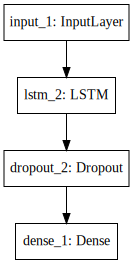

In [7]:
# Building the model
lstm_units  = 100
inputs      = Input(shape = x_train[0].shape)

layer       = LSTM(units            = lstm_units,
                   return_sequences = False,
                   activation       = 'selu')(inputs)

layer       = Dropout(0.2)(layer)

layer       = LSTM(units            = lstm_units,
                   return_sequences = False,
                   activation       = 'selu')(inputs)

layer       = Dropout(0.2)(layer)

predictions = Dense(units      = 1,
                    activation = 'linear')(layer)

model       = Model(inputs, predictions)

model.compile(loss      = 'mse',
              optimizer = 'adadelta')

# Visual representation of net.
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
# Fitting the RNN to the Training set
history = model.fit(x                = x_train,
                    y                = y_train,
                    batch_size       = len(x_train),
                    epochs           = 500,
                    validation_split = 0.2,
                    verbose          = 0,
                    shuffle          = False,
                    callbacks        = [TQDMNotebookCallback() ])#EarlyStopping(patience = 3)])

HBox(children=(IntProgress(value=0, description='Training', max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=363), HTML(value='')))

In [9]:
# Comparing our model's output, given the training data, to the expected output.
actual_prices_train       = sc.inverse_transform(y_train)[:-1]
predicted_BTC_price_train = sc.inverse_transform(model.predict(x_train))[1:]

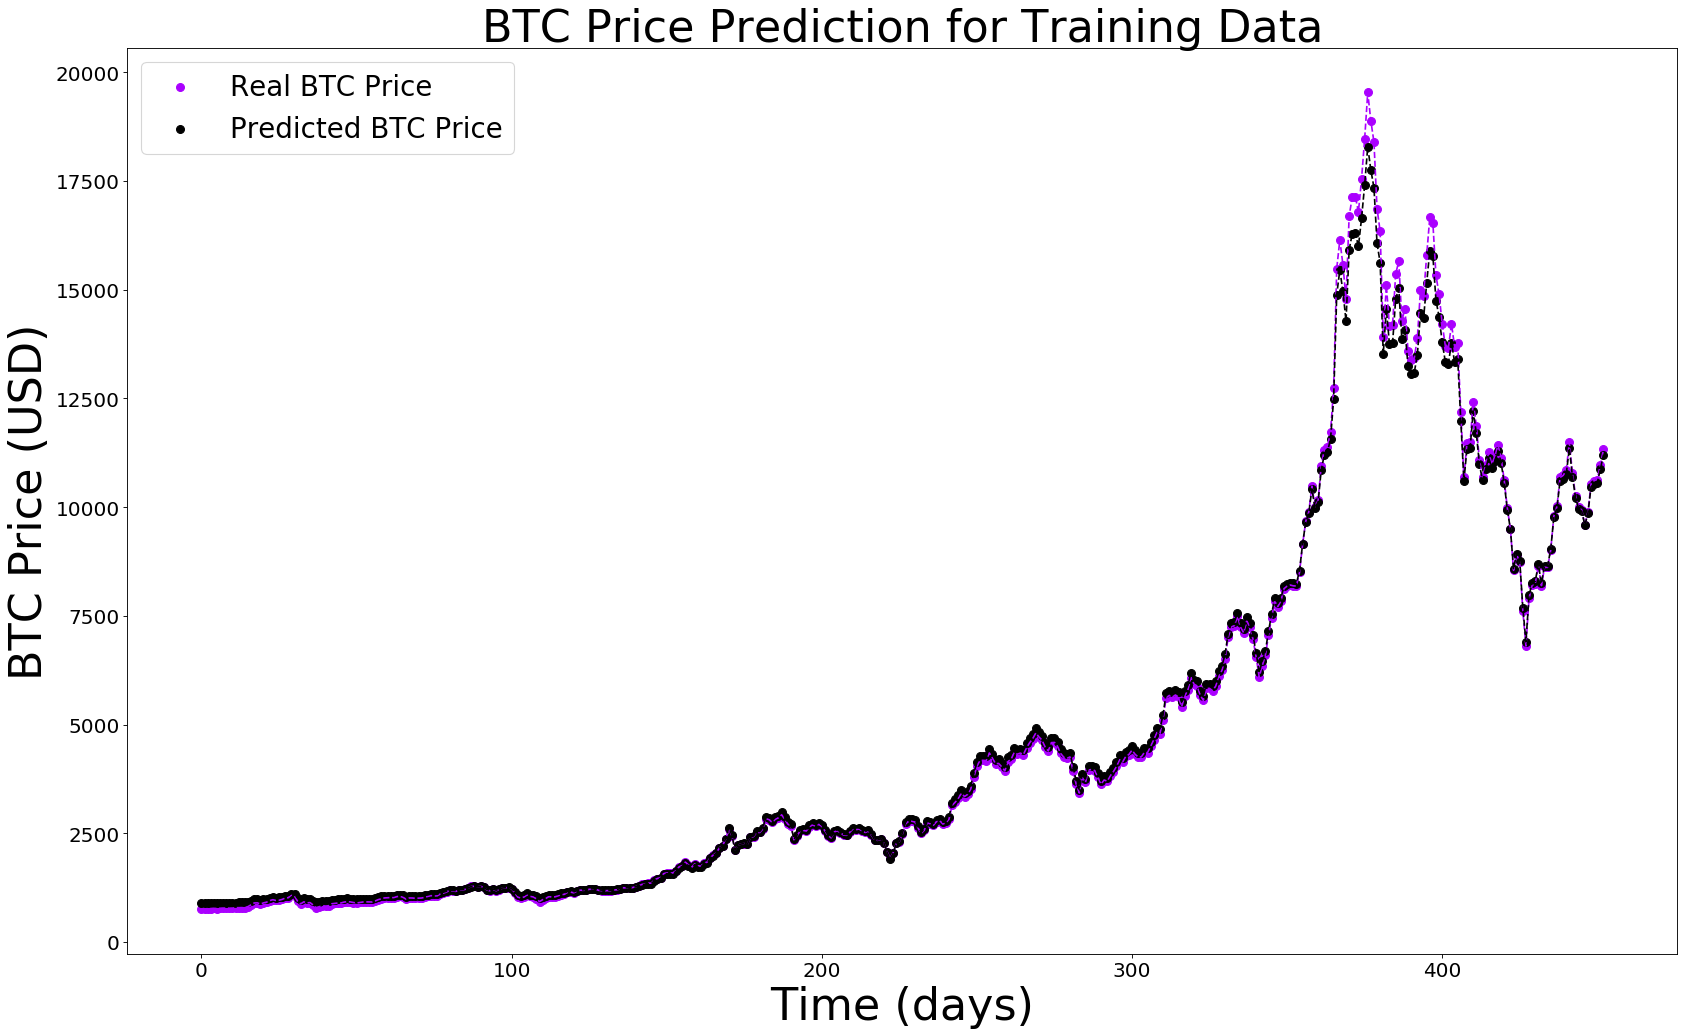

In [10]:
Plot(actual_prices_train, predicted_BTC_price_train, \
     "BTC Price Prediction for Training Data", "Real BTC Price", "Predicted BTC Price", "BTC Price (USD)")

In [11]:
#Predicting the future.
actual_prices_test       = sc.inverse_transform(y_test)[:-1]
predicted_BTC_price_test = sc.inverse_transform(model.predict(x_test))[1:]

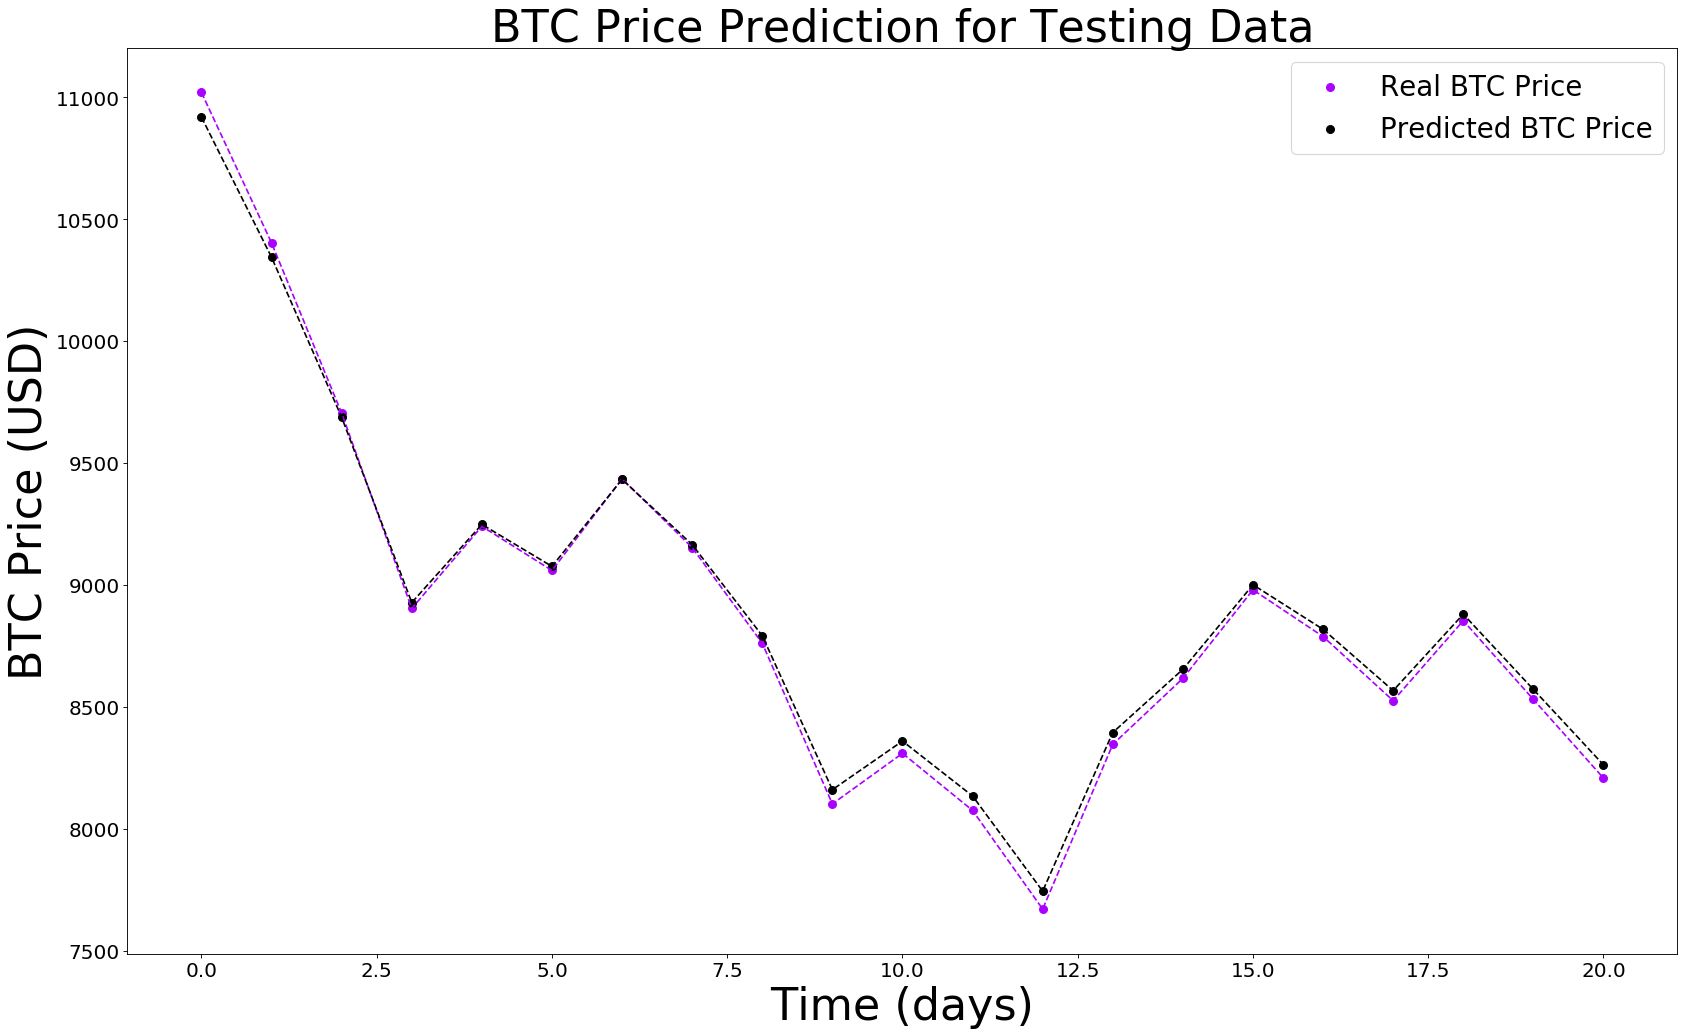

In [12]:
Plot(actual_prices_test, predicted_BTC_price_test, "BTC Price Prediction for Testing Data", "Real BTC Price", "Predicted BTC Price", "BTC Price (USD)")